Epoch 1/5
1929/1929 - 6s - loss: 0.0765 - val_loss: 0.0037 - 6s/epoch - 3ms/step
Epoch 2/5
1929/1929 - 4s - loss: 0.0042 - val_loss: 0.0034 - 4s/epoch - 2ms/step
Epoch 3/5
1929/1929 - 4s - loss: 0.0041 - val_loss: 0.0034 - 4s/epoch - 2ms/step
Epoch 4/5
1929/1929 - 5s - loss: 0.0040 - val_loss: 0.0037 - 5s/epoch - 3ms/step
Epoch 5/5
1929/1929 - 5s - loss: 0.0040 - val_loss: 0.0033 - 5s/epoch - 3ms/step
1/1 [==============================] - 0s 16ms/step
                       Time  Predicted Wind Speed (km/h)
0 2016-12-31 23:00:00+00:00                    13.326062
1 2017-01-01 00:00:00+00:00                    -5.232175
2 2017-01-01 01:00:00+00:00                    17.788372
3 2017-01-01 02:00:00+00:00                    16.154408
4 2017-01-01 03:00:00+00:00                    14.799011


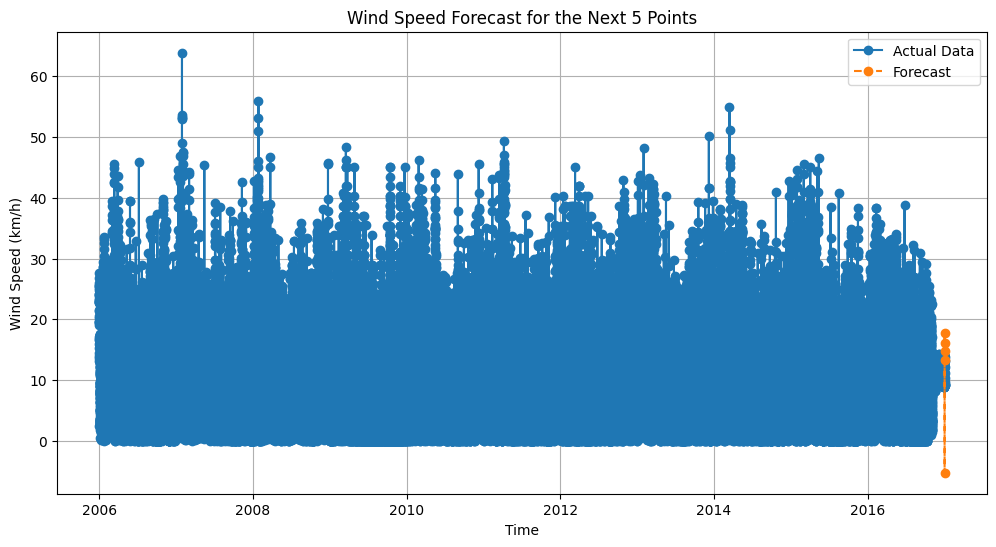

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/New folder/data_prepration/windspeed_data.csv')  # Replace 'your_dataset.csv' with the actual file path

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Wind Speed (km/h)', 'Hour']]

# Normalize the wind speed values
scaler = MinMaxScaler()
data[['Wind Speed (km/h)']] = scaler.fit_transform(data[['Wind Speed (km/h)']])

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Wind Speed (km/h)', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Wind Speed (km/h)'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_wind_speeds = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next wind speed
    next_wind_speed = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]
    
    # Update the sequence with the predicted wind speed and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_wind_speed, df['Hour'].iloc[-num_points_to_predict + _]])])
    
    # Store the predicted wind speed
    forecasted_wind_speeds.append(next_wind_speed)

# Denormalize the forecasted wind speeds
forecasted_wind_speeds = scaler.inverse_transform(np.array(forecasted_wind_speeds).reshape(-1, 1))

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Wind Speed (km/h)': forecasted_wind_speeds.flatten()})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Wind Speed (km/h)'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Wind Speed (km/h)'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Wind Speed Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import joblib
# Save the model
model.save('D:/RNN_based_airfield/models/Windspeed_model.h5')
# Save the scaler
joblib.dump({'min_': scaler.min_, 'scale_': scaler.scale_}, 'D:/RNN_based_airfield/models/Windspeed_Scaler.joblib')

['D:/RNN_based_airfield/models/Windspeed_Scaler.joblib']

# non scaled

Epoch 1/5
1929/1929 - 6s - loss: 12.8693 - val_loss: 12.4700 - 6s/epoch - 3ms/step
Epoch 2/5
1929/1929 - 6s - loss: 12.3801 - val_loss: 12.8857 - 6s/epoch - 3ms/step
Epoch 3/5
1929/1929 - 6s - loss: 12.2870 - val_loss: 12.1062 - 6s/epoch - 3ms/step
Epoch 4/5
1929/1929 - 6s - loss: 12.2207 - val_loss: 11.9896 - 6s/epoch - 3ms/step
Epoch 5/5
1929/1929 - 5s - loss: 12.1631 - val_loss: 12.0734 - 5s/epoch - 3ms/step
1/1 [==============================] - 0s 24ms/step
                       Time  Predicted Wind Speed (km/h)
0 2016-12-31 23:00:00+00:00                    13.141995
1 2017-01-01 00:00:00+00:00                    12.604148
2 2017-01-01 01:00:00+00:00                    12.240741
3 2017-01-01 02:00:00+00:00                    11.281218
4 2017-01-01 03:00:00+00:00                    10.168818
5 2017-01-01 04:00:00+00:00                     9.445807


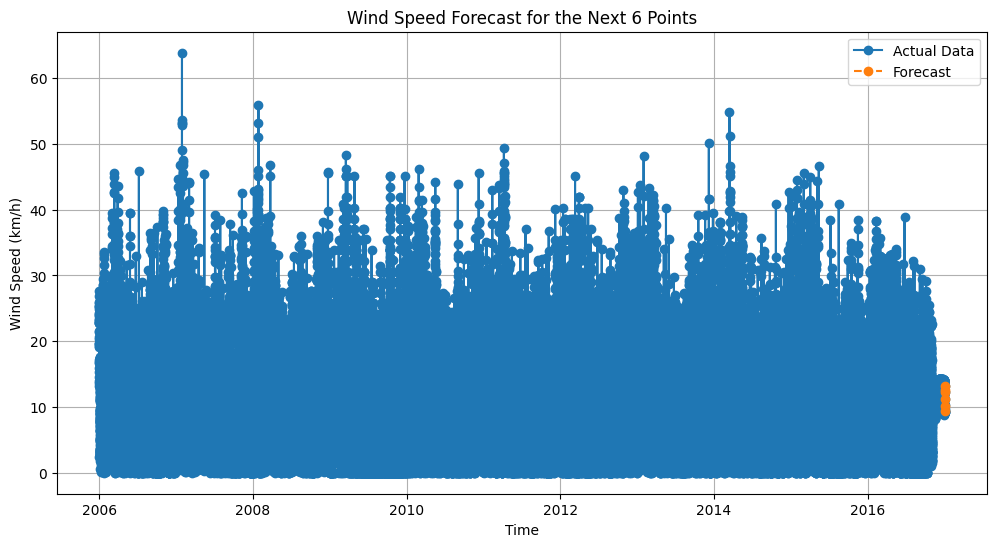

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/New folder/data_prepration/windspeed_data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Wind Speed (km/h)', 'Hour']]

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Wind Speed (km/h)', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Wind Speed (km/h)'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_wind_speeds = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next wind speed
    next_wind_speed = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]
    
    # Update the sequence with the predicted wind speed and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_wind_speed, df['Hour'].iloc[-num_points_to_predict + _]])])
    
    # Store the predicted wind speed
    forecasted_wind_speeds.append(next_wind_speed)

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Wind Speed (km/h)': forecasted_wind_speeds})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Wind Speed (km/h)'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Wind Speed (km/h)'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Wind Speed Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import joblib
# Save the model
model.save('D:/AF_scratch/nonscaledmodel/Windspeed_model.h5')

Epoch 1/5
1929/1929 - 5s - loss: 13.9545 - val_loss: 12.3001 - 5s/epoch - 3ms/step
Epoch 2/5
1929/1929 - 4s - loss: 12.3908 - val_loss: 12.0765 - 4s/epoch - 2ms/step
Epoch 3/5
1929/1929 - 4s - loss: 12.2805 - val_loss: 12.1054 - 4s/epoch - 2ms/step
Epoch 4/5
1929/1929 - 4s - loss: 12.2194 - val_loss: 12.1660 - 4s/epoch - 2ms/step
Epoch 5/5
1929/1929 - 4s - loss: 12.2110 - val_loss: 12.3035 - 4s/epoch - 2ms/step
1/1 [==============================] - 0s 18ms/step
                       Time  Predicted Wind Speed (km/h)
0 2016-12-31 23:00:00+00:00                    13.782956
1 2017-01-01 00:00:00+00:00                    13.112733
2 2017-01-01 01:00:00+00:00                    12.503992
3 2017-01-01 02:00:00+00:00                    11.791000


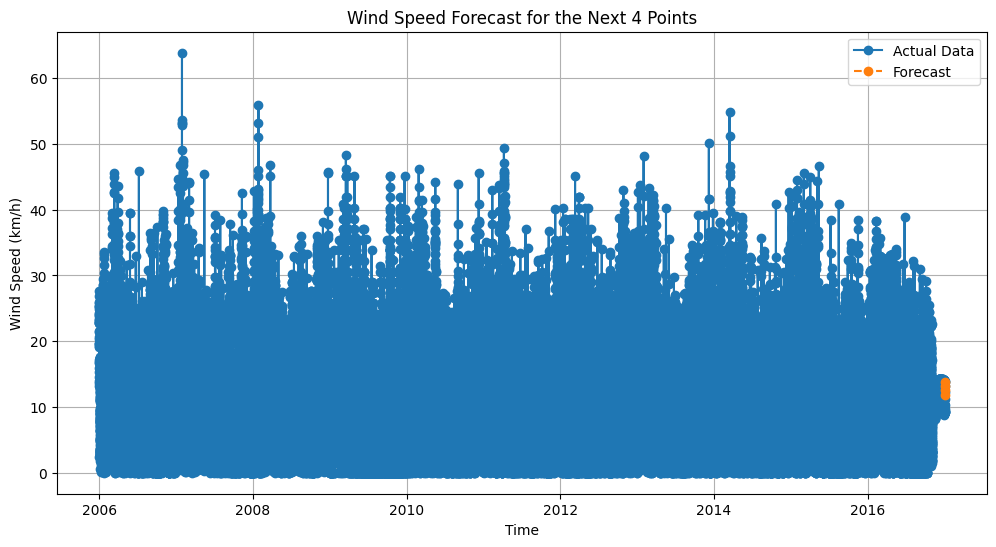

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/New folder/data_prepration/windspeed_data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Wind Speed (km/h)', 'Hour']]

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Wind Speed (km/h)', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Wind Speed (km/h)'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_wind_speeds = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next wind speed
    next_wind_speed = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]
    
    # Update the sequence with the predicted wind speed and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_wind_speed, df['Hour'].iloc[-num_points_to_predict + _]])])
    
    # Store the predicted wind speed
    forecasted_wind_speeds.append(next_wind_speed)

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Wind Speed (km/h)': forecasted_wind_speeds})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Wind Speed (km/h)'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Wind Speed (km/h)'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Wind Speed Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.legend()
plt.grid(True)
plt.show()
